# 🚀 Mô Hình Dự Báo Giá Bitcoin Với BiLSTM

Notebook này hướng dẫn bạn từng bước để xây dựng và huấn luyện mô hình dự báo giá Bitcoin.

---

## 📋 Checklist

- [ ] Bước 1: Lấy dữ liệu từ Binance
- [ ] Bước 2: Xử lý dữ liệu
- [ ] Bước 3: Xây dựng model BiLSTM
- [ ] Bước 4: Training model
- [ ] Bước 5: Đánh giá & Vẽ biểu đồ

---

## 💡 Tips

1. Chạy từng cell theo thứ tự từ trên xuống dưới
2. Đọc comments trong code để hiểu
3. Nếu cần giải thích chi tiết, xem `docs/` folder
4. Nghỉ giải lao nếu cảm thấy ngợp!

## 📦 0. Setup & Cấu Hình

Cấu hình TensorFlow và import các thư viện cần thiết.

In [37]:
# Import thư viện
import numpy as np
import polars as pl
import tensorflow as tf
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import modules từ project
# Note: Notebook đang chạy từ notebooks/, cần up 1 cấp để tới project root
import sys
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from utils.runtime import configure_tensorflow_runtime, print_tensorflow_info, set_random_seed

# Cố định seed để tái lập kết quả (nếu SEED < 0 thì bỏ qua)
try:
    set_random_seed(SEED, deterministic=True)
except NameError:
    # Nếu cell cấu hình chưa chạy, fallback seed mặc định
    set_random_seed(42, deterministic=True)

# Cấu hình TensorFlow cho CPU AMD
configure_tensorflow_runtime(
    intra_op_threads=12,
    inter_op_threads=2,
    enable_xla=True
)

# In thông tin TensorFlow
print_tensorflow_info()

⚙️  CẤU HÌNH TENSORFLOW RUNTIME
Intra-op threads: 12
Inter-op threads: 2
XLA enabled: True
CPU only: True


📋 THÔNG TIN TENSORFLOW
TensorFlow version: 2.20.0
Keras version: 3.13.0
Built with CUDA: True
ℹ️  Không tìm thấy GPU, sẽ dùng CPU
GPU available: False
Intra-op threads: 12
Inter-op threads: 2



## 🔧 1. Cấu Hình Tham Số

Thay đổi các tham số tùy ý:

In [38]:
# ==================== CẤU HÌNH ====================

# Reproducibility
SEED = 42  # Đổi seed để chạy thử nghiệm; đặt <0 để không cố định

# Symbol
SYMBOL = "BTC/USDT"  # Trading pair symbol

# Data parameters (CSV local)
# Sử dụng project_root để tìm đường dẫn đúng (notebook chạy từ notebooks/)
# Đảm bảo Path được import (đã import trong cell 2, nhưng fallback để chắc chắn)
try:
    from pathlib import Path
except ImportError:
    pass

try:
    # project_root đã được định nghĩa trong cell 2
    data_file_relative = "data/btc_1d_data_2018_to_2025.csv"  # Đổi sang 4h nếu muốn: data/btc_4h_data_2018_to_2025.csv
    DATA_PATH = str(project_root / data_file_relative)
except NameError:
    # Fallback nếu project_root chưa được định nghĩa (chạy cell này trước cell 2)
    project_root = Path.cwd().parent
    data_file_relative = "data/btc_1d_data_2018_to_2025.csv"
    DATA_PATH = str(project_root / data_file_relative)

LIMIT = 1500                                      # Lấy N dòng cuối (<=0 = lấy tất cả)
REFRESH_CACHE = False                             # True = đọc lại CSV gốc, False = dùng cache normalized

def infer_timeframe_from_filename(path: str) -> str:
    name = path.lower()
    if "4h" in name:
        return "4h"
    if "1d" in name:
        return "1d"
    return "unknown"

TIMEFRAME = infer_timeframe_from_filename(DATA_PATH)  # Hiển thị timeframe dựa vào tên file

# Preprocessing parameters
WINDOW_SIZE = 100            # Số nến nhìn lại (sliding window)
FEATURES = ["close"]       # Features sử dụng

# Model parameters
LSTM_UNITS = [64, 32]       # Số units cho mỗi LSTM layer
DROPOUT_RATE = 0.2         # Dropout rate

# Training parameters
EPOCHS = 20                 # Số epochs
BATCH_SIZE = 32             # Batch size
EARLY_STOPPING_PATIENCE = 5 # Số epochs chờ trước khi dừng

# Print cấu hình
print("="*60)
print("⚙️  CẤU HÌNH")
print("="*60)
print(f"Seed: {SEED}")
print(f"Data path: {DATA_PATH}")
print(f"Timeframe (from filename): {TIMEFRAME}")
print(f"Limit (tail): {LIMIT}")
print(f"Window size: {WINDOW_SIZE}")
print(f"Features: {FEATURES}")
print(f"LSTM units: {LSTM_UNITS}")
print(f"Dropout: {DROPOUT_RATE}")
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print("="*60 + "\n")

⚙️  CẤU HÌNH
Seed: 42
Data path: /home/ultimatebrok/Downloads/deep_learning/data/btc_1d_data_2018_to_2025.csv
Timeframe (from filename): 1d
Limit (tail): 1500
Window size: 100
Features: ['close']
LSTM units: [64, 32]
Dropout: 0.2
Epochs: 20
Batch size: 32



---

## 📥 BƯỚC 1: ĐỌC DỮ LIỆU CSV (LOCAL)

### Giải thích:
- Đọc dữ liệu giá từ file CSV local (mặc định: `data/btc_1d_data_2018_to_2025.csv`)
- Chuẩn hoá về DataFrame với: datetime, open, high, low, close, volume
- Cache (optional) file CSV đã chuẩn hoá để lần sau đọc nhanh hơn

In [39]:
from step1_data import fetch_binance_data

# Đọc dữ liệu (CSV local)
df = fetch_binance_data(
    data_path=DATA_PATH,
    timeframe=TIMEFRAME,
    limit=LIMIT,
    save_cache=not REFRESH_CACHE
)

# In 5 dòng đầu tiên
print("\n📊 5 dòng đầu tiên của dữ liệu:")
print(df.head())

# Thống kê cơ bản
print("\n📊 Thống kê dữ liệu:")
print(df.describe())

# Đánh dấu checklist
print("\n✅ Bước 1 hoàn thành!")

📂 Đang đọc dữ liệu từ cache: /home/ultimatebrok/Downloads/deep_learning/step1_data/cache/btc_1d_data_2018_to_2025_1d_1500.normalized.csv

📊 5 dòng đầu tiên của dữ liệu:
shape: (5, 6)
┌─────────────────────┬──────────┬──────────┬──────────┬──────────┬─────────────┐
│ datetime            ┆ open     ┆ high     ┆ low      ┆ close    ┆ volume      │
│ ---                 ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---         │
│ datetime[μs]        ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64         │
╞═════════════════════╪══════════╪══════════╪══════════╪══════════╪═════════════╡
│ 2021-11-18 00:00:00 ┆ 60344.86 ┆ 60976.0  ┆ 56474.26 ┆ 56891.62 ┆ 62146.99931 │
│ 2021-11-19 00:00:00 ┆ 56891.62 ┆ 58320.0  ┆ 55600.0  ┆ 58052.24 ┆ 50715.88726 │
│ 2021-11-20 00:00:00 ┆ 58057.1  ┆ 59845.0  ┆ 57353.0  ┆ 59707.51 ┆ 33811.5901  │
│ 2021-11-21 00:00:00 ┆ 59707.52 ┆ 60029.76 ┆ 58486.65 ┆ 58622.02 ┆ 31902.22785 │
│ 2021-11-22 00:00:00 ┆ 58617.7  ┆ 59444.0  ┆ 55610.0  ┆ 56247.18 ┆ 51724.32047

### Vẽ biểu đồ lịch sử giá

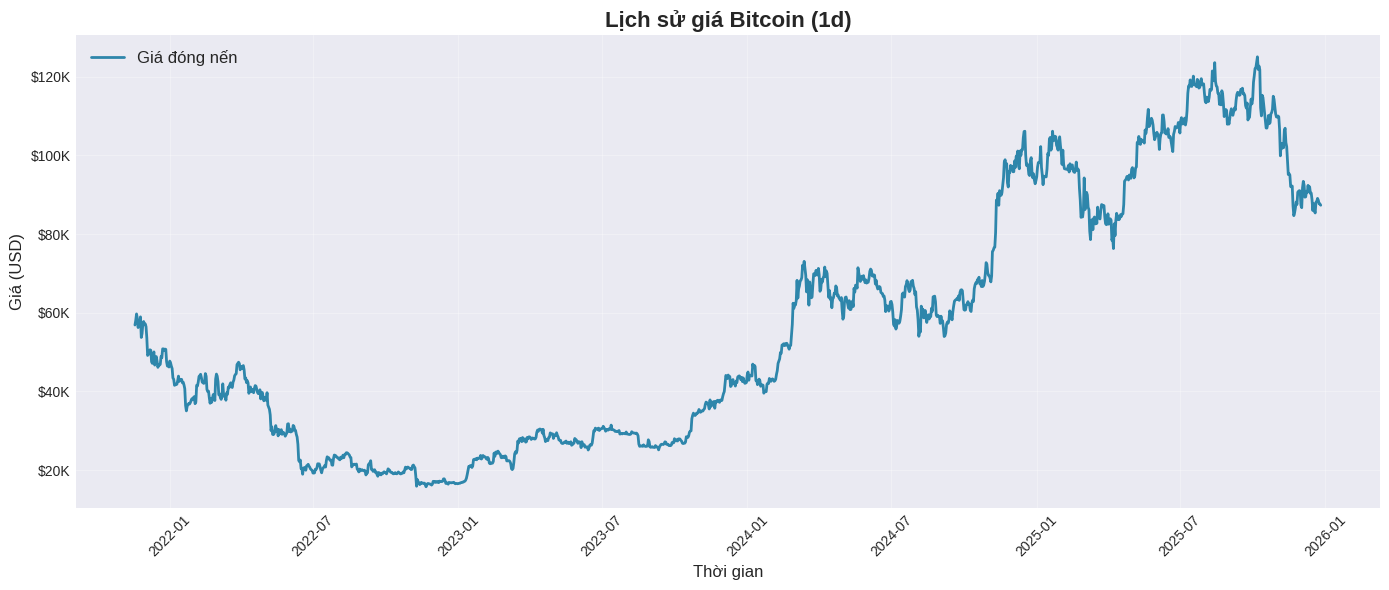

In [40]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure(figsize=(14, 6))
plt.plot(df['datetime'], df['close'], linewidth=2, color='#2E86AB', label='Giá đóng nến')
plt.title(f'Lịch sử giá Bitcoin ({TIMEFRAME})', fontsize=16, fontweight='bold')
plt.xlabel('Thời gian', fontsize=12)
plt.ylabel('Giá (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
plt.tight_layout()
plt.show()

---

## 🔨 BƯỚC 2: XỬ LÝ DỮ LIỆU

### Giải thích:
- **Scaling**: Đưa dữ liệu về khoảng [0, 1] để model học tốt hơn
- **Chống data leakage**: scaler được **fit chỉ trên tập train**, sau đó mới transform val/test
- **Sliding Window**: Tạo sequences (60 ngày trước → dự đoán ngày tiếp theo)
- **Split Data**: Chia thành train (80%), val (10%), test (10%)

In [41]:
from step2_preprocessing import prepare_data_for_lstm

# Pipeline xử lý dữ liệu hoàn chỉnh
data_dict = prepare_data_for_lstm(
    df=df,
    features=FEATURES,
    window_size=WINDOW_SIZE,
    scaler_type='minmax'
)

# Lấy các biến
X_train = data_dict['X_train']
y_train = data_dict['y_train']
X_val = data_dict['X_val']
y_val = data_dict['y_val']
X_test = data_dict['X_test']
y_test = data_dict['y_test']
scaler = data_dict['scaler']

# Đánh dấu checklist
print("\n✅ Bước 2 hoàn thành!")

📦 Dữ liệu gốc shape: (1500, 1)
✅ Đã tạo 1400 windows:
   X shape: (1400, 100, 1) (samples, window_size, features)
   y shape: (1400, 1, 1) (samples, predict_steps)
📊 Chia dữ liệu:
   Train: 1120 samples (80.0%)
   Val: 140 samples (10.0%)
   Test: 140 samples (9.999999999999995%)
✅ Đã fit và transform dữ liệu với minmax scaler
   Min: 0.0000, Max: 1.0000

✅ Bước 2 hoàn thành!


### Kiểm tra shapes của dữ liệu

In [42]:
print("\n" + "="*60)
print("📊 SHAPES CỦA DỮ LIỆU")
print("="*60)
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}")
print(f"y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}")
print("="*60 + "\n")


📊 SHAPES CỦA DỮ LIỆU
X_train: (1120, 100, 1)
y_train: (1120, 1)
X_val:   (140, 100, 1)
y_val:   (140, 1)
X_test:  (140, 100, 1)
y_test:  (140, 1)



---

## 🧠 BƯỚC 3: XÂY DỰNG MODEL BiLSTM

### Giải thích:
- **BiLSTM**: LSTM hai chiều (nhìn cả quá khứ và tương lai)
- **Dropout**: Bỏ ngẫu nhiên neurons để tránh overfitting
- **Dense layers**: Kết hợp features để đưa ra dự đoán

In [43]:
from step3_model import build_bilstm_model, print_model_summary

# Xây dựng model
input_shape = (WINDOW_SIZE, len(FEATURES))
model = build_bilstm_model(
    input_shape=input_shape,
    lstm_units=LSTM_UNITS,
    dropout_rate=DROPOUT_RATE,
    dense_units=[16],
    output_units=1
)

# In thông tin model
print_model_summary(model)

# Đánh dấu checklist
print("\n✅ Bước 3 hoàn thành!")

✅ Đã build model BiLSTM với 2 LSTM layers

MODEL SUMMARY


Model: "BiLSTM_Price_Prediction"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 100, 128)       │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_dropout_1 (Dropout)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,065 (297.13 KB)

 Trainable params: 76,065 (297.13 KB)

 Non-trainable params: 0 (0.00 B)


📊 Thống kê:
   Total parameters: 76,065
   Trainable: 76,065
   Non-trainable: 0

✅ Bước 3 hoàn thành!


---

## 🏋️ BƯỚC 4: TRAINING MODEL

### Giải thích:
- **ModelCheckpoint**: Lưu lại model tốt nhất
- **EarlyStopping**: Dừng nếu val_loss không giảm
- **ReduceLROnPlateau**: Giảm learning rate nếu không cải thiện

In [44]:
from step4_training import train_model

# Training
train_result = train_model(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    early_stopping_patience=EARLY_STOPPING_PATIENCE
)

# Lấy training history
history = train_result['history']

# Metadata training (để đưa vào report)
best_epoch = train_result.get('best_epoch')
best_val_loss = train_result.get('best_val_loss')
train_seconds = train_result.get('train_seconds')
checkpoint_path = str(train_result.get('checkpoint_path')) if train_result.get('checkpoint_path') is not None else None

print(f"\n📌 Best epoch: {best_epoch}")
print(f"📌 Best val_loss: {best_val_loss}")
print(f"📌 Training time (s): {train_seconds}")

# Đánh dấu checklist
print("\n✅ Bước 4 hoàn thành!")


🚀 BẮT ĐẦU TRAINING
Epochs: 20
Batch size: 32
Train samples: 1120
Val samples: 140
Checkpoint: /home/ultimatebrok/Downloads/deep_learning/reports/checkpoints/best_model.keras

Epoch 1/20
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0436 - mae: 0.1378

2025-12-27 00:49:04.339208: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Epoch 1: val_loss improved from None to 0.00979, saving model to /home/ultimatebrok/Downloads/deep_learning/reports/checkpoints/best_model.keras

Epoch 1: finished saving model to /home/ultimatebrok/Downloads/deep_learning/reports/checkpoints/best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0222 - mae: 0.0990 - val_loss: 0.0098 - val_mae: 0.0843 - learning_rate: 0.0010
Epoch 2/20
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0085 - mae: 0.0603
Epoch 2: val_loss improved from 0.00979 to 0.00969, saving model to /home/ultimatebrok/Downloads/deep_learning/reports/checkpoints/best_model.keras

Epoch 2: finished saving model to /home/ultimatebrok/Downloads/deep_learning/reports/checkpoints/best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0088 - mae: 0.0613 - val_loss: 0.0097 - val_mae: 0.0869 - learning_rate: 0.0010
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0065 - mae: 0.0535
Epoch 3: val_loss improved from 0.00969 to 0.00196, savi

### Vẽ biểu đồ training history

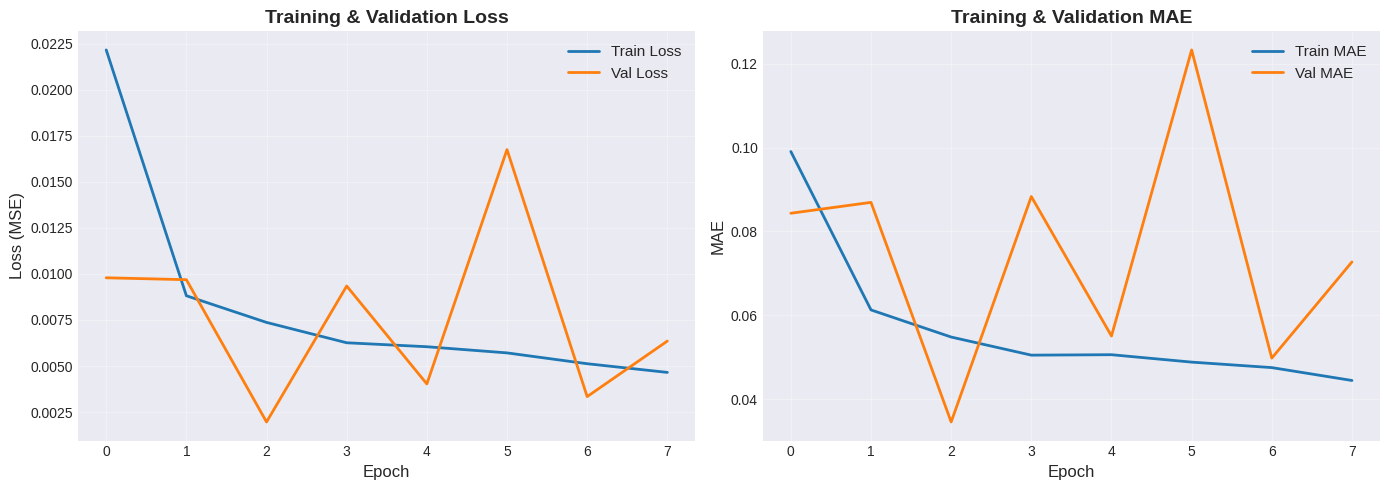

In [45]:
from step5_visualization import plot_training_history

plot_training_history(history)

---

## 📊 BƯỚC 5: ĐÁNH GIÁ & VẼ BIỂU ĐỒ

### Giải thích:
- **MAE**: Sai số trung bình tuyệt đối (USD)
- **RMSE**: Căn bậc 2 của sai số bình phương trung bình (USD)
- **MAPE**: Sai số phần trăm trung bình (%)

In [46]:
from step4_training import evaluate_model, print_sample_predictions, calculate_direction_accuracy
from step5_visualization import plot_predictions, plot_all_in_one

# Đánh giá trên test set
eval_result = evaluate_model(
    model=model,
    X_test=X_test,
    y_test=y_test,
    scaler=scaler,
    return_predictions=True
)

# Lấy dự đoán và giá trị thật
y_true = eval_result['y_true']
y_pred = eval_result['predictions']

2025-12-27 00:49:12.744663: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



📊 KẾT QUẢ ĐÁNH GIÁ TRÊN TEST SET / TEST SET EVALUATION
MAE:  $4003.50  (Sai số trung bình tuyệt đối / Mean Absolute Error)
RMSE: $5033.05  (Căn bậc 2 sai số bình phương / Root Mean Squared Error)
MAPE: 3.90%  (Sai số phần trăm trung bình / Mean Absolute Percentage Error)



In [47]:
# In một số ví dụ dự đoán
print_sample_predictions(y_true, y_pred, n_samples=10)


VÍ DỤ DỰ ĐOÁN (đầu 10 mẫu) / SAMPLE PREDICTIONS (first 10)
STT/# Thực tế/Actual  Dự đoán/Pred    Sai số/Error    % Sai số/%Err
------------------------------------------------------------
1     $116506.38     $112952.34     $3554.04       3.05     %
2     $116734.75     $112980.78     $3753.97       3.22     %
3     $121459.83     $113062.30     $8397.53       6.91     %
4     $118968.74     $113543.59     $5425.15       4.56     %
5     $119274.59     $113875.52     $5399.07       4.53     %
6     $123568.65     $114239.48     $9329.17       7.55     %
7     $118749.03     $114896.16     $3852.87       3.24     %
8     $117666.79     $115168.70     $2498.09       2.12     %
9     $117407.92     $115276.95     $2130.97       1.82     %
10    $115802.33     $115337.66     $464.67        0.40     %



In [48]:
# Tính độ chính xác xu hướng
direction_accuracy = calculate_direction_accuracy(y_true, y_pred)

# Lưu vào eval_result để report/metrics.json có thêm thông tin
eval_result['direction_accuracy'] = float(direction_accuracy)

📈 Độ chính xác xu hướng / Direction accuracy: 51.08%


### Vẽ biểu đồ predictions vs actual

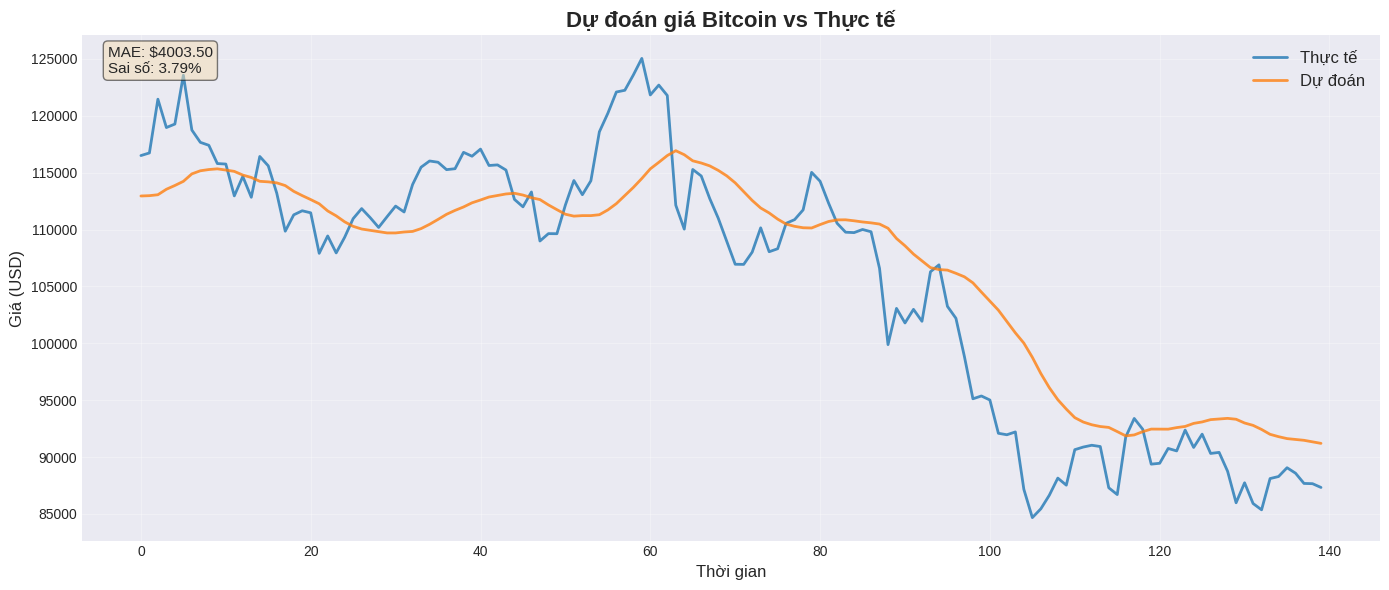

In [49]:
plot_predictions(y_true, y_pred)

### Vẽ biểu đồ tổng hợp (all-in-one)

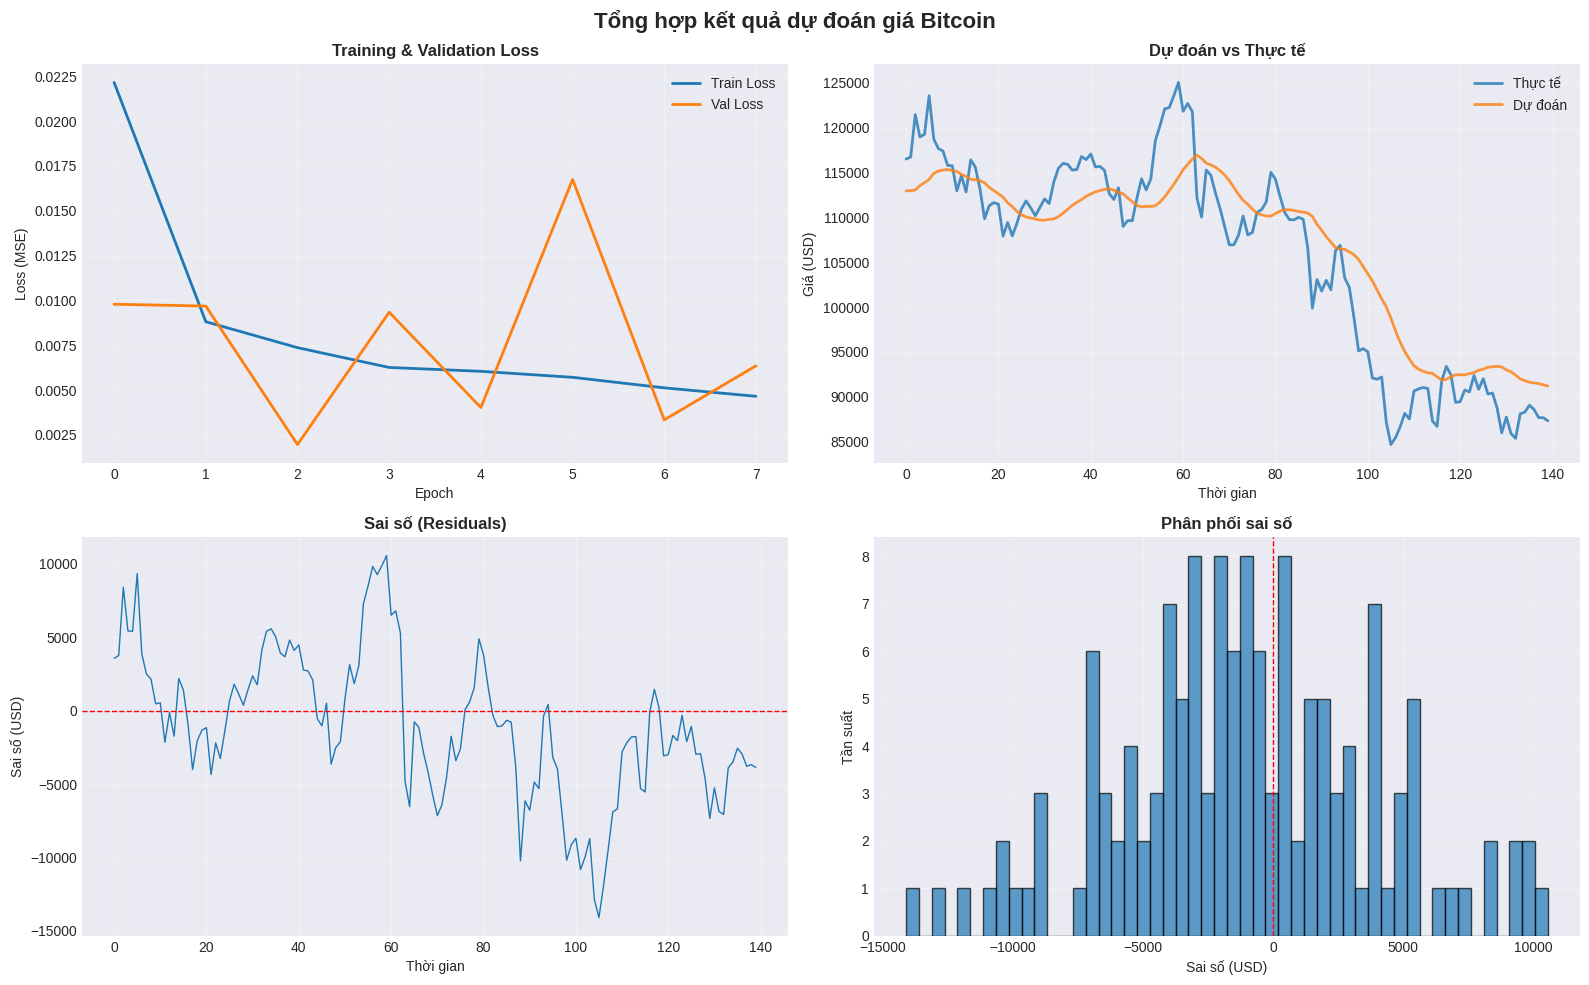

In [50]:
plot_all_in_one(history, y_true, y_pred)

---

## 💾 LƯU KẾT QUẢ

Tất cả kết quả được lưu vào thư mục `reports/notebook/`

📁 Folder kết quả: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_20251227_004913

💾 Đã lưu training history plot: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_20251227_004913/training_history_20251227_004913.png


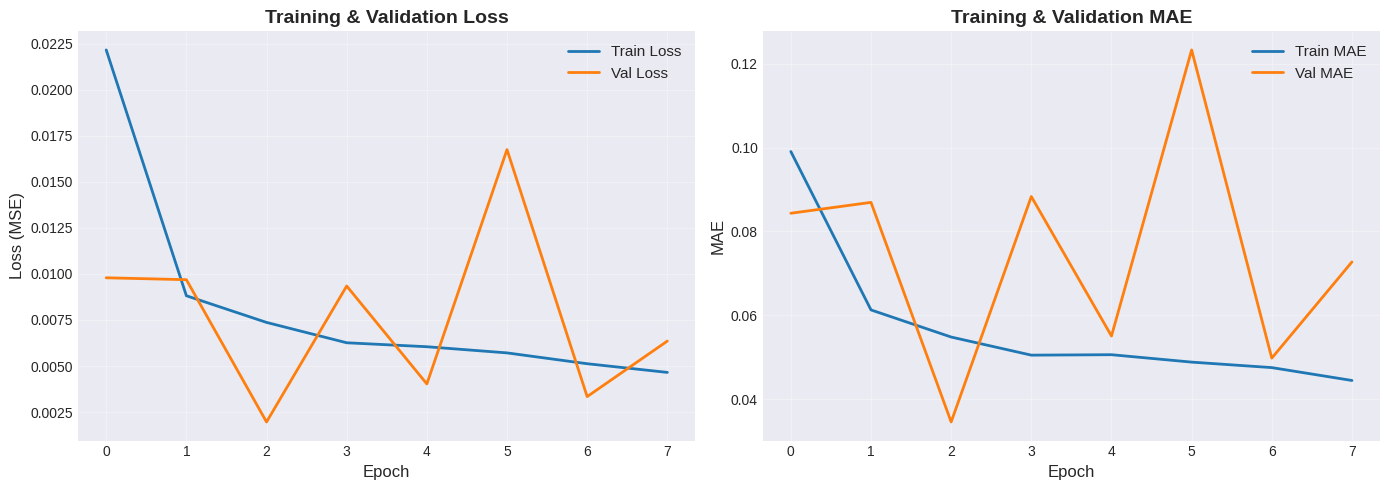

💾 Đã lưu predictions plot: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_20251227_004913/predictions_20251227_004913.png


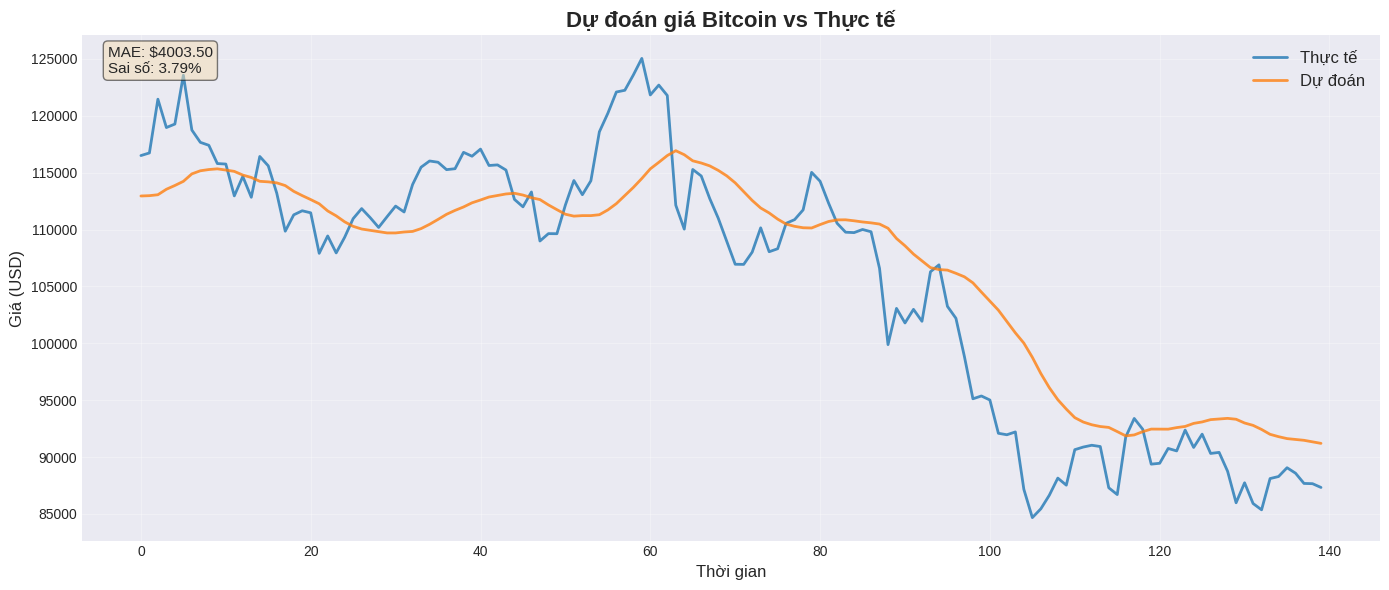

💾 Đã lưu all-in-one plot: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_20251227_004913/all_in_one_20251227_004913.png


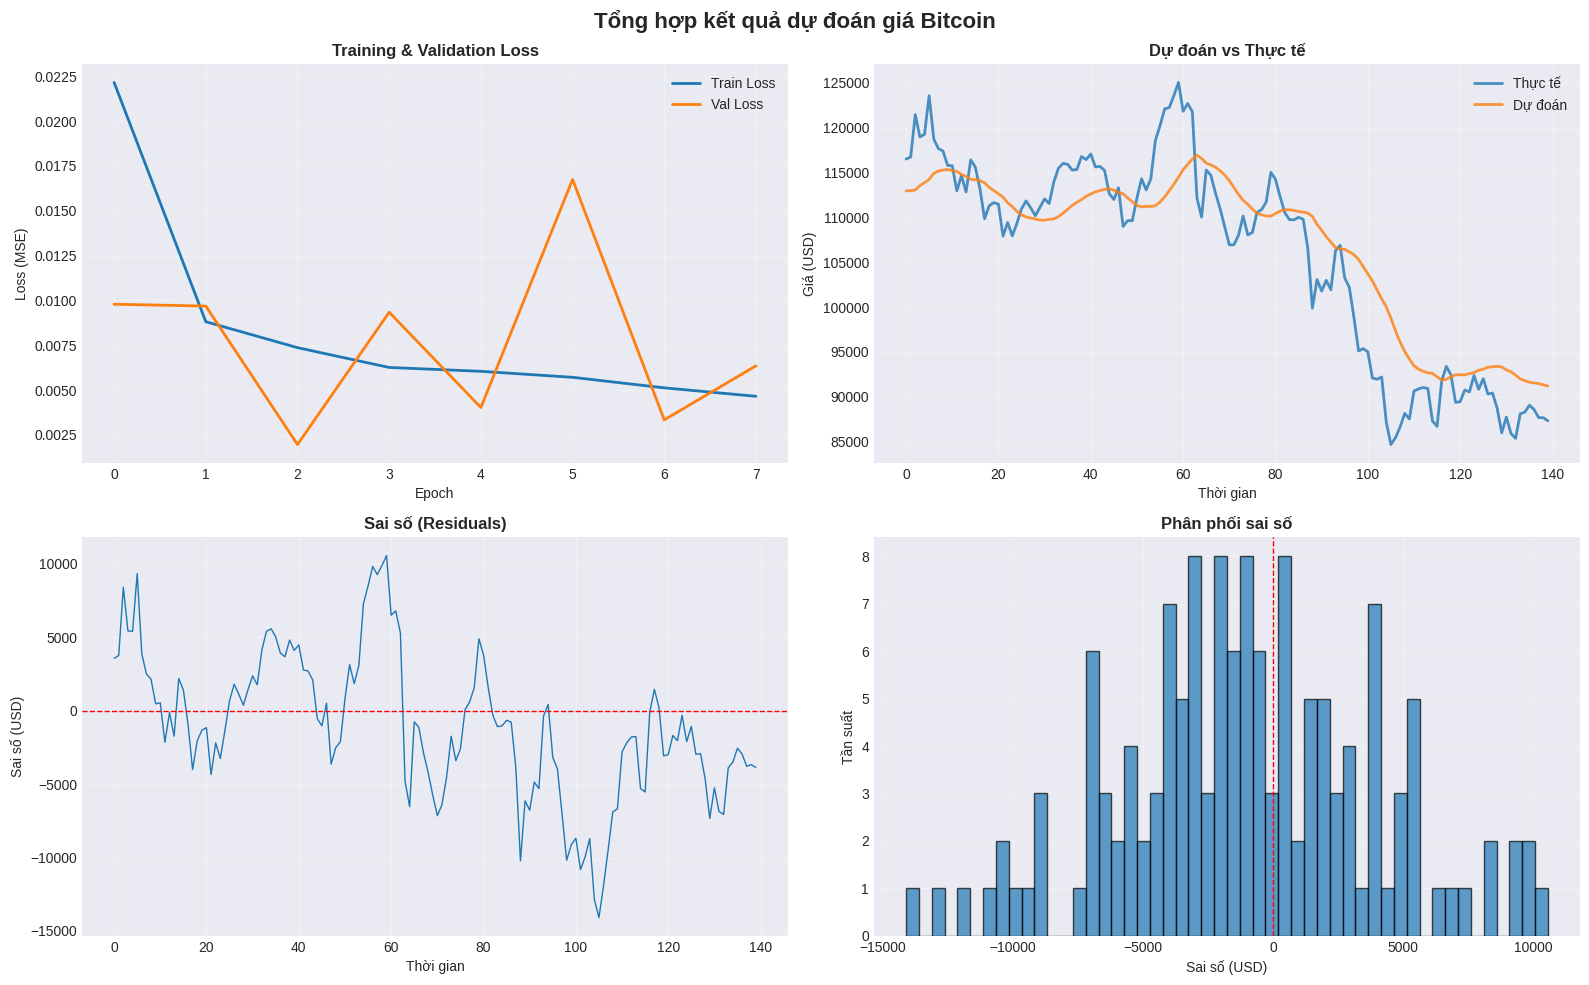

💾 Đã lưu báo cáo Markdown: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_20251227_004913/results_BiLSTM_20251227_004913.md
💾 Đã lưu cấu hình: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_20251227_004913/config.json
💾 Đã lưu metrics: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_20251227_004913/metrics.json

✅ Bước 5 hoàn thành!


In [51]:
from utils import create_results_folder, save_markdown_report, save_config, save_metrics

# Tạo folder kết quả
results_folder = create_results_folder(run_type="notebook")
print(f"📁 Folder kết quả: {results_folder}\n")

# Tạo suffix cho tên file
timestamp_suffix = results_folder.name.replace('BiLSTM_', '')

# Vẽ và lưu biểu đồ
plot_history_file = results_folder / f"training_history_{timestamp_suffix}.png"
plot_predictions_file = results_folder / f"predictions_{timestamp_suffix}.png"
plot_all_in_one_file = results_folder / f"all_in_one_{timestamp_suffix}.png"

plot_training_history(history, save_path=str(plot_history_file))
plot_predictions(y_true, y_pred, save_path=str(plot_predictions_file))
plot_all_in_one(history, y_true, y_pred, save_path=str(plot_all_in_one_file))

# Metadata dữ liệu
try:
    data_rows = len(df)
    # Polars DataFrame: sử dụng .row() hoặc .select()
    data_start = str(df.select('datetime').row(0)[0])
    data_end = str(df.select('datetime').row(-1)[0])
except Exception:
    try:
        # Fallback: thử cách khác
        data_start = str(df['datetime'].min())
        data_end = str(df['datetime'].max())
    except Exception:
        data_rows, data_start, data_end = None, None, None

# Metadata split
train_samples = len(X_train)
val_samples = len(X_val)
test_samples = len(X_test)
scaler_type = 'minmax'

# Chuẩn bị config và metrics
config_dict = {
    'data_path': DATA_PATH,  # Thêm data_path để hiển thị Source CSV
    'symbol': SYMBOL,
    'timeframe': TIMEFRAME,
    'limit': LIMIT,
    'data_rows': data_rows,
    'data_start': data_start,
    'data_end': data_end,
    'window_size': WINDOW_SIZE,
    'features': FEATURES,
    'scaler_type': scaler_type,
    'train_samples': train_samples,
    'val_samples': val_samples,
    'test_samples': test_samples,
    'seed': SEED,
    'lstm_units': LSTM_UNITS,
    'dropout_rate': DROPOUT_RATE,
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE,
    'early_stopping_patience': EARLY_STOPPING_PATIENCE,
    'best_epoch': best_epoch,
    'best_val_loss': best_val_loss,
    'train_seconds': train_seconds,
    'checkpoint_path': checkpoint_path,
}

plots_dict = {
    'training_history': timestamp_suffix,
    'predictions': timestamp_suffix,
    'all_in_one': timestamp_suffix
}

# Lưu báo cáo
save_markdown_report(
    folder_path=results_folder,
    config=config_dict,
    metrics=eval_result,
    history=history.history,
    plots=plots_dict
)
save_config(results_folder, config_dict)
save_metrics(results_folder, eval_result)

# Đánh dấu checklist
print("\n✅ Bước 5 hoàn thành!")

---

## 🎉 HOÀN THÀNH!

### Checklist:
- [x] Bước 1: Lấy dữ liệu từ Binance
- [x] Bước 2: Xử lý dữ liệu
- [x] Bước 3: Xây dựng model BiLSTM
- [x] Bước 4: Training model
- [x] Bước 5: Đánh giá & Vẽ biểu đồ

### Kết quả:
- Báo cáo Markdown: `reports/notebook/BiLSTM_YYYYMMDD_HHMMSS/results_*.md`
- Biểu đồ: Các file PNG trong cùng folder
- Config & Metrics: File JSON trong cùng folder

### Tiếp theo:
- Thử thay đổi các tham số (window size, LSTM units, v.v.)
- Thêm các features khác (volume, open, high, low)
- Thử timeframe khác (4h, 1h)

**Chúc bạn thành công! 🚀**